# Person re-identification 

### This sample use simple pretrained resnet-152 model to extract features/embeddings for an image 

### Compute Embedding

In [1]:
images_dir = "./tests/imagesMarket1501/"

In [2]:
import sys
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader

sys.path.append(os.path.abspath('./src'))
from resnetembedding import ResnetEmbedder
from datasets.Market1501Dataset import Market1501Dataset
from EuclideanPairwiseDistance import EuclideanPairwiseDistance
from CMCScore import CMCScore


In [4]:
%%time 

dataset = Market1501Dataset(images_dir)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

model = ResnetEmbedder()

embeddings = []
class_person = []
    
for person_img, target in dataloader:
    embedding = model(person_img)
    embeddings.extend(embedding)
    class_person.extend(target)

embeddings = torch.stack(embeddings)
class_person = torch.stack(class_person)


CPU times: user 652 ms, sys: 241 ms, total: 893 ms
Wall time: 994 ms


In [5]:
class_person

tensor([0, 0, 1, 1, 1, 1])

In [6]:
embeddings[0:5]

tensor([[ 2.0860, -0.9623, -2.3659,  ..., -3.2209, -0.7173, -1.7405],
        [ 2.3526,  0.6473, -1.2543,  ..., -1.3970,  0.4834, -2.4779],
        [ 2.5060, -0.8358,  1.3550,  ..., -2.4177,  0.1918, -1.9069],
        [ 0.6304, -3.1290, -0.3387,  ..., -3.4402, -0.3905, -0.9481],
        [ 2.4416, -1.7486, -0.9557,  ...,  0.8624,  0.1731, -0.3458]])

In [7]:
embeddings.shape

torch.Size([6, 1000])

### Compute pairwise distance

In [8]:
distance_metric = EuclideanPairwiseDistance()
pairwise_distance = distance_metric(embeddings)
pairwise_distance

tensor([[ 0.0000, 47.7461, 59.2575, 54.4379, 60.4004, 49.9503],
        [47.7461,  0.0000, 51.1608, 55.9461, 53.2815, 53.2512],
        [59.2575, 51.1608,  0.0000, 35.2323, 52.3397, 49.1692],
        [54.4379, 55.9461, 35.2323,  0.0000, 55.4175, 47.1983],
        [60.4004, 53.2815, 52.3397, 55.4175,  0.0000, 39.8705],
        [49.9503, 53.2512, 49.1692, 47.1983, 39.8705,  0.0000]])

### Compute CMC score
Definition: https://www.nist.gov/sites/default/files/documents/2016/12/06/12_ross_cmc-roc_ibpc2016.pdf

* Each sample is  compared against all gallery samples. The resulting scores are sorted and ranked

* Determine the rank at which a true match occurs 
* True Positive Identification Rate (TPIR): Probability of observing the correct identity within the top K ranks
* CMC Curve: Plots TPIR against ranks
* CMC Curve: Rank based metric



In [9]:
from EuclideanPairwiseDistance import EuclideanPairwiseDistance

distance_metric = EuclideanPairwiseDistance()
pairwise_distance = distance_metric(embeddings)
pairwise_distance


tensor([[ 0.0000, 47.7461, 59.2575, 54.4379, 60.4004, 49.9503],
        [47.7461,  0.0000, 51.1608, 55.9461, 53.2815, 53.2512],
        [59.2575, 51.1608,  0.0000, 35.2323, 52.3397, 49.1692],
        [54.4379, 55.9461, 35.2323,  0.0000, 55.4175, 47.1983],
        [60.4004, 53.2815, 52.3397, 55.4175,  0.0000, 39.8705],
        [49.9503, 53.2512, 49.1692, 47.1983, 39.8705,  0.0000]])

In [10]:
class_person

tensor([0, 0, 1, 1, 1, 1])

In [11]:
from CMCScore import CMCScore

cmc_scorer = CMCScore()
score = cmc_scorer.score(pairwise_distance, class_person, 1)
print(score)

100.0


In [12]:
k=1
accuracy, rank_k, rank_k_label = cmc_scorer.accuracy_at_top_k(pairwise_distance,  class_person, k)
print("Percentage accuracy at k = {} is {}".format(k, accuracy ))

Percentage accuracy at k = 1 is 100.0


In [13]:
rank_k

tensor([[1],
        [0],
        [3],
        [2],
        [5],
        [4]])

In [14]:
result_df = pd.DataFrame(rank_k_label, columns= ["predicted_k_{}".format(i) for i in range(1, k+1)])
result_df["actual"] = class_person

In [15]:
result_df.head(n=20)

,predicted_k_1,actual
0,0,0
1,0,0
2,1,1
3,1,1
4,1,1
5,1,1


### Visualise the embeddings extracted using T-SNE

In [16]:
!pip install scikit-learn==0.21.2

In [17]:
from sklearn.manifold import TSNE
embedding_tsne = TSNE(random_state=42).fit_transform(embeddings)

print("embeddings reduced to 2-D using TSNE\n")
print(embedding_tsne[0:10])

embeddings reduced to 2-D using TSNE

[[  -4.8392267  -20.266273 ]
 [ -75.25943   -117.774086 ]
 [ -75.60325      2.502517 ]
 [ -55.89032    -57.579678 ]
 [-119.12415    -57.761086 ]
 [  -4.6277866  -94.602425 ]]


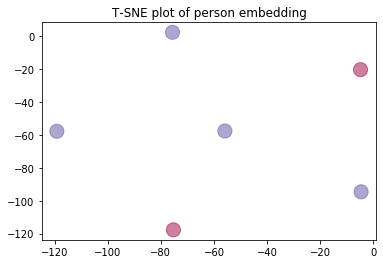

In [18]:
group = list(set(class_person))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

scatter = ax.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c= class_person, alpha=0.5, s= 200, cmap="Spectral" )

plt.title('T-SNE plot of person embedding')
plt.show()